In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tracker
import stats
import metrics
import visualizer
import utils

import importlib

import pandas as pd

# Run Stats One at a Time

In [15]:
# prediction = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_predicted.csv"
# groundtruth = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_corrected.csv"
# subopt = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_predicted_old.csv"
# videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1.mp4"

# prediction = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_predicted.csv"
# groundtruth = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_corrected.csv"
# subopt = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_predicted_old.csv"
# videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1.mp4"

prediction = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_predicted.csv"
groundtruth = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_corrected.csv"
subopt = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_predicted_old.csv"
videofile = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1.mp4"

# Load as Pandas DataFrame
pred_src = utils.loadDataFrame(prediction)
gt_src = utils.loadDataFrame(groundtruth)
subopt_src = utils.loadDataFrame(subopt)

# Drop duplicates, interpolate, and filter sperm
pred_dd = utils.dropDuplicates(pred_src)
gt_dd = utils.dropDuplicates(gt_src)
subopt_dd = utils.dropDuplicates(subopt_src)

pred = utils.interpolateTracks(pred_dd)
gt = utils.interpolateTracks(gt_dd)
subopt = utils.interpolateTracks(subopt_dd)

pred = metrics.filterSperm(pred)
gt = metrics.filterSperm(gt)
subopt = metrics.filterSperm(subopt)


# print(len(pred_src), len(gt_src), len(subopt_src))
# print("Unique sperm in prediction source:", len(pred_src['sperm'].unique()))
# print("Unique sperm in ground truth source:", len(gt_src['sperm'].unique()))
# print("Unique sperm in suboptimal source:", len(subopt_src['sperm'].unique()))

# print(len(pred), len(gt), len(subopt))
# # Count number of unique sperm in each DataFrame
# print("Unique sperm in prediction:", len(pred['sperm'].unique()))
# print("Unique sperm in ground truth:", len(gt['sperm'].unique()))
# print("Unique sperm in suboptimal:", len(subopt['sperm'].unique()))



In [16]:
# Compute stats for each file
ps = 1/1.0476  # pixel size in micrometers
fps = 9    # frames per second
gt = stats.computeAllStats(gt,fps=fps,pixel_size=ps,interpolate=False)
pred = stats.computeAllStats(pred,fps=fps,pixel_size=ps,interpolate=False)
subopt = stats.computeAllStats(subopt,fps=fps,pixel_size=ps,interpolate=False)



In [17]:
# Compute earth movers distance between distributions
import pandas as pd
from scipy.stats import wasserstein_distance

emd_df = pd.DataFrame({"Method": ["Prediction", "Suboptimal"], "VAP": [None, None], "VSL": [None, None], "VCL": [None, None], "ALH_mean": [None, None], "ALH_max": [None, None], "BCF": [None, None]})


# Compute EMD for each statistic
for stat in ["VAP", "VSL", "VCL", "ALH_mean", "ALH_max", "BCF"]:
    emd_df.loc[0, stat] = wasserstein_distance(gt[stat], pred[stat])
    emd_df.loc[1, stat] = wasserstein_distance(gt[stat], subopt[stat])

# Print the EMD DataFrame
print(emd_df)

       Method       VAP       VSL       VCL   ALH_mean     ALH_max       BCF
0  Prediction  1.728363  1.485895  1.892129  21.864685   23.127242   0.02815
1  Suboptimal  8.201437  5.432561  7.971516  74.841676  105.673739  0.030063


In [18]:
#print(pred.head())


# Print maxes of each stat for each file as a dataframe
summary_df = pd.DataFrame({
    'Stat': ['VAP', 'VSL', 'VCL', 'ALH_mean', 'ALH_max', 'BCF'],
    'Prediction': [pred['VAP'].max(), pred['VSL'].max(), pred['VCL'].max(), pred['ALH_mean'].max(), pred['ALH_max'].max(), pred['BCF'].max()],
    'Ground Truth': [gt['VAP'].max(), gt['VSL'].max(), gt['VCL'].max(), gt['ALH_mean'].max(), gt['ALH_max'].max(), gt['BCF'].max()],
    'Suboptimal': [subopt['VAP'].max(), subopt['VSL'].max(), subopt['VCL'].max(), subopt['ALH_mean'].max(), subopt['ALH_max'].max(), subopt['BCF'].max()]
})

print(summary_df)

#print("Mins:",gt["VAP"].min(), gt["VSL"].min(), gt["VCL"].min(), gt["ALH_mean"].min(), gt["ALH_max"].min(), gt["BCF"].min())


       Stat  Prediction  Ground Truth  Suboptimal
0       VAP   67.666302     67.673850   47.319600
1       VSL   67.050718     67.068163   49.585016
2       VCL   68.811171     69.436975   47.947709
3  ALH_mean  535.277648    535.784650  345.420472
4   ALH_max  684.123603    683.607445  618.182887
5       BCF    0.480916      0.671053    0.870968


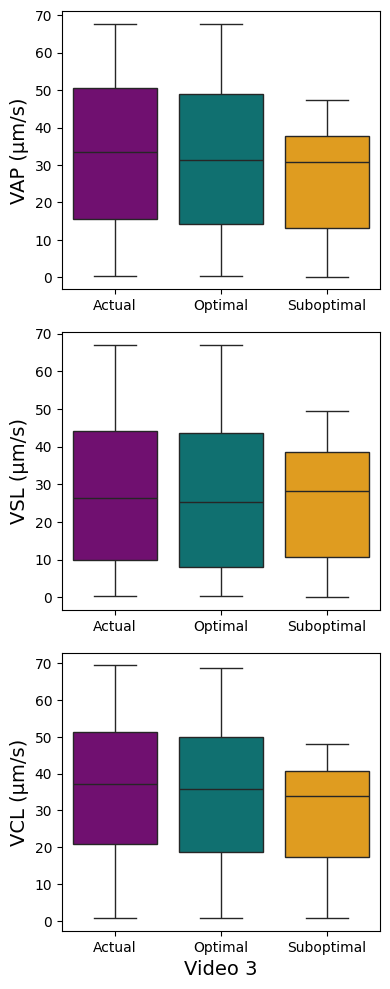

In [20]:
# Same plot, but with side by side box plots

pred_vap = pred.groupby('sperm').first()['VAP']
pred_vsl = pred.groupby('sperm').first()['VSL']
pred_vcl = pred.groupby('sperm').first()['VCL']
# pred_alh_mean = pred.groupby('sperm').first()['ALH_mean']
# pred_alh_max = pred.groupby('sperm').first()['ALH_max']
# pred_bcf = pred.groupby('sperm').first()['BCF']

gt_vap = gt.groupby('sperm').first()['VAP']
gt_vsl = gt.groupby('sperm').first()['VSL']
gt_vcl = gt.groupby('sperm').first()['VCL']
# gt_alh_mean = gt.groupby('sperm').first()['ALH_mean']
# gt_alh_max = gt.groupby('sperm').first()['ALH_max']
# gt_bcf = gt.groupby('sperm').first()['BCF']

subopt_vap = subopt.groupby('sperm').first()['VAP']
subopt_vsl = subopt.groupby('sperm').first()['VSL']
subopt_vcl = subopt.groupby('sperm').first()['VCL']
# subopt_alh_mean = subopt.groupby('sperm').first()['ALH_mean']
# subopt_alh_max = subopt.groupby('sperm').first()['ALH_max']
# subopt_bcf = subopt.groupby('sperm').first()['BCF']

import math
vap_max = math.ceil(max(pred_vap.max(), gt_vap.max(), subopt_vap.max()))
vsl_max = math.ceil(max(pred_vsl.max(), gt_vsl.max(), subopt_vsl.max()))
vcl_max = math.ceil(max(pred_vcl.max(), gt_vcl.max(), subopt_vcl.max()))
# alh_mean_max = math.ceil(max(pred_alh_mean.max(), gt_alh_mean.max(), subopt_alh_mean.max()))
# alh_max_max = math.ceil(max(pred_alh_max.max(), gt_alh_max.max(), subopt_alh_max.max()))
# bcf_max = math.ceil(max(pred_bcf.max(), gt_bcf.max(), subopt_bcf.max()))

# Create dataframe for box plots side-by-side with seaborn
import pandas as pd

# Concatenate the series for each method
df = pd.DataFrame({
    'Data': (['Actual'] * len(gt_vap)) + (['Optimal'] * len(pred_vap)) + (['Suboptimal'] * len(subopt_vap)),
    'VAP': pd.concat([gt_vap, pred_vap, subopt_vap], ignore_index=True),
    'VSL': pd.concat([gt_vsl, pred_vsl, subopt_vsl], ignore_index=True),
    'VCL': pd.concat([gt_vcl, pred_vcl, subopt_vcl], ignore_index=True),
    # 'ALH_mean': pd.concat([gt_alh_mean, pred_alh_mean, subopt_alh_mean], ignore_index=True),
    # 'ALH_max': pd.concat([gt_alh_max, pred_alh_max, subopt_alh_max], ignore_index=True),
    # 'BCF': pd.concat([gt_bcf, pred_bcf, subopt_bcf], ignore_index=True)
})

fig, axs = plt.subplots(3, 1, figsize=(4, 10))

import seaborn as sns
colors = {'Actual': 'purple', 'Optimal': 'teal', 'Suboptimal': 'orange'}
sns.boxplot(x="Data", y="VAP", hue="Data", data=df, palette=colors, ax=axs[0])
sns.boxplot(x="Data", y="VSL", hue="Data", data=df, palette=colors, ax=axs[1])
sns.boxplot(x="Data", y="VCL", hue="Data", data=df, palette=colors, ax=axs[2])

axs[0].set_ylabel("VAP (µm/s)", fontsize=14)
axs[1].set_ylabel("VSL (µm/s)", fontsize=14)
axs[2].set_ylabel("VCL (µm/s)", fontsize=14)

axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[2].set_xlabel("Video 3", fontsize=14)

plt.tight_layout()
plt.show()

fig.savefig("boxchart3.jpg", dpi=300)

## Run Stats Combined

In [8]:
examples = {}
examples["video1"] = {
    "prediction" : "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_predicted.csv",
    "groundtruth" : "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_corrected.csv",
    "subopt" : "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_predicted_subopt.csv",
    "videofile" : "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1.mp4"
}

examples["video2"] = {
    "prediction" : "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_predicted.csv",
    "groundtruth" : "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_corrected.csv",
    "subopt" : "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_predicted_subopt.csv",
    "videofile" : "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1.mp4"
}
examples["video3"] = {
    "prediction" : "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_predicted.csv",
    "groundtruth" : "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_corrected.csv",
    "subopt" : "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_predicted_subopt.csv",
    "videofile" : "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1.mp4"
}

examples["video4"] = {
    "prediction" : "Comparisons/10X Ph- 9Fps Wash 1 16 P019as R3_predicted.csv",
    "groundtruth" : "Comparisons/10X Ph- 9Fps Wash 1 16 P019as R3_corrected.csv",
    "subopt" : "Comparisons/10X Ph- 9Fps Wash 1 16 P019as R3_predicted_subopt.csv",
    "videofile" : "Comparisons/10X Ph- 9Fps Wash 1 16 P019as R3.mp4"
}

examples["video5"] = {
    "prediction" : "Comparisons/10X Ph- 9Fps Wash 1 16 Cap P020sh R2_predicted.csv",
    "groundtruth" : "Comparisons/10X Ph- 9Fps Wash 1 16 Cap P020sh R2_corrected.csv",
    "subopt" : "Comparisons/10X Ph- 9Fps Wash 1 16 Cap P020sh R2_predicted_subopt.csv",
    "videofile" : "Comparisons/10X Ph- 9Fps Wash 1 16 Cap P020sh R2.mp4"
}


In [9]:
all_gt = pd.DataFrame()
all_pred = pd.DataFrame()
all_subopt = pd.DataFrame()

for key, example in examples.items():
    prediction = example["prediction"]
    groundtruth = example["groundtruth"]
    subopt = example["subopt"]
    videofile = example["videofile"]

    # Load as Pandas DataFrame
    pred_src = utils.loadDataFrame(prediction)
    gt_src = utils.loadDataFrame(groundtruth)
    subopt_src = utils.loadDataFrame(subopt)

    # Drop duplicates, interpolate, and filter sperm
    pred_dd = utils.dropDuplicates(pred_src)
    gt_dd = utils.dropDuplicates(gt_src)
    subopt_dd = utils.dropDuplicates(subopt_src)

    pred = utils.interpolateTracks(pred_dd)
    gt = utils.interpolateTracks(gt_dd)
    subopt = utils.interpolateTracks(subopt_dd)

    pred = metrics.filterSperm(pred)
    gt = metrics.filterSperm(gt)
    subopt = metrics.filterSperm(subopt)

    # Compute stats for each file
    ps = 1/1.0476  # pixel size in micrometers
    fps = 9    # frames per second
    gt = stats.computeAllStats(gt,fps=fps,pixel_size=ps,interpolate=False)
    pred = stats.computeAllStats(pred,fps=fps,pixel_size=ps,interpolate=False)
    subopt = stats.computeAllStats(subopt,fps=fps,pixel_size=ps,interpolate=False)

    # Get unique stats for each sperm
    pred_unique = pred.groupby('sperm').first()
    gt_unique = gt.groupby('sperm').first()
    subopt_unique = subopt.groupby('sperm').first()

    # Grab VAP, VSL, VCL columns
    pred_unique = pred_unique[['VAP', 'VSL', 'VCL']]
    gt_unique = gt_unique[['VAP', 'VSL', 'VCL']]
    subopt_unique = subopt_unique[['VAP', 'VSL', 'VCL']]

    # Save to dataframe
    all_gt = pd.concat([all_gt, gt_unique], ignore_index=True)
    all_pred = pd.concat([all_pred, pred_unique], ignore_index=True)
    all_subopt = pd.concat([all_subopt, subopt_unique], ignore_index=True)
    


In [10]:
import pandas as pd
from scipy.stats import wasserstein_distance

emd_df = pd.DataFrame({"Method": ["Prediction", "Suboptimal"], "VAP": [None, None], "VSL": [None, None], "VCL": [None, None]})


# Compute EMD for each statistic
for stat in ["VAP", "VSL", "VCL"]:
    emd_df.loc[0, stat] = wasserstein_distance(all_gt[stat], all_pred[stat])
    emd_df.loc[1, stat] = wasserstein_distance(all_gt[stat], all_subopt[stat])

# Print the EMD DataFrame
print(emd_df)

       Method       VAP       VSL       VCL
0  Prediction  3.397848  2.787829  3.589557
1  Suboptimal  7.210877  3.380726  7.178755


In [11]:
#print(pred.head())


# Print maxes of each stat for each file as a dataframe
summary_df = pd.DataFrame({
    'Stat': ['VAP', 'VSL', 'VCL'],
    'Prediction': [all_pred['VAP'].max(), all_pred['VSL'].max(), all_pred['VCL'].max()],
    'Ground Truth': [all_gt['VAP'].max(), all_gt['VSL'].max(), all_gt['VCL'].max()],
    'Suboptimal': [all_subopt['VAP'].max(), all_subopt['VSL'].max(), all_subopt['VCL'].max()]
})

print(summary_df)

#print("Mins:",gt["VAP"].min(), gt["VSL"].min(), gt["VCL"].min(), gt["ALH_mean"].min(), gt["ALH_max"].min(), gt["BCF"].min())


  Stat  Prediction  Ground Truth  Suboptimal
0  VAP  100.169799    100.185223   48.687294
1  VSL  100.167857    100.137057   51.459878
2  VCL  101.662588    102.021313   49.506838


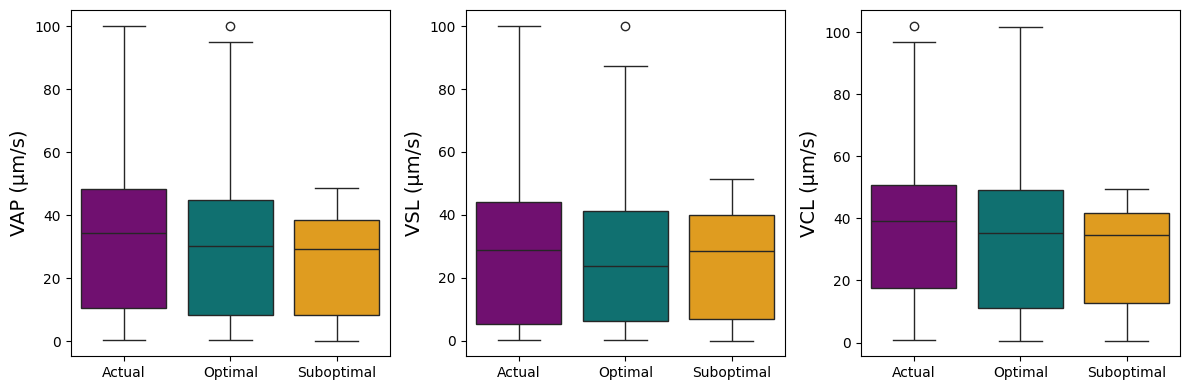

In [13]:
# Same plot, but with side by side box plots

pred_vap = all_pred['VAP']
pred_vsl = all_pred['VSL']
pred_vcl = all_pred['VCL']

gt_vap = all_gt['VAP']
gt_vsl = all_gt['VSL']
gt_vcl = all_gt['VCL']

subopt_vap = all_subopt['VAP']
subopt_vsl = all_subopt['VSL']
subopt_vcl = all_subopt['VCL']

import math
vap_max = math.ceil(max(pred_vap.max(), gt_vap.max(), subopt_vap.max()))
vsl_max = math.ceil(max(pred_vsl.max(), gt_vsl.max(), subopt_vsl.max()))
vcl_max = math.ceil(max(pred_vcl.max(), gt_vcl.max(), subopt_vcl.max()))

# Create dataframe for box plots side-by-side with seaborn
import pandas as pd

# Concatenate the series for each method
df = pd.DataFrame({
    'Data': (['Actual'] * len(gt_vap)) + (['Optimal'] * len(pred_vap)) + (['Suboptimal'] * len(subopt_vap)),
    'VAP': pd.concat([gt_vap, pred_vap, subopt_vap], ignore_index=True),
    'VSL': pd.concat([gt_vsl, pred_vsl, subopt_vsl], ignore_index=True),
    'VCL': pd.concat([gt_vcl, pred_vcl, subopt_vcl], ignore_index=True),
})

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

import seaborn as sns
colors = {'Actual': 'purple', 'Optimal': 'teal', 'Suboptimal': 'orange'}
sns.boxplot(x="Data", y="VAP", hue="Data", data=df, palette=colors, ax=axs[0])
sns.boxplot(x="Data", y="VSL", hue="Data", data=df, palette=colors, ax=axs[1])
sns.boxplot(x="Data", y="VCL", hue="Data", data=df, palette=colors, ax=axs[2])

axs[0].set_ylabel("VAP (µm/s)", fontsize=14)
axs[1].set_ylabel("VSL (µm/s)", fontsize=14)
axs[2].set_ylabel("VCL (µm/s)", fontsize=14)

axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[2].set_xlabel("", fontsize=14)

plt.tight_layout()
plt.show()

fig.savefig("boxchart.jpg", dpi=300)